Real Helmholtz Expanded 2cm
===========================

This uses the FEMME model RHelmS2 which puts point 1A/mm2 currents through 2cm tall by 0.8cm thick coils centered at x=50cm, y=$\pm$26cm in a 1m radius sphere with 'infinite' boundary. This differs from the RealHelmholtz model in having the coils set 2cm further apart.

Start by loading some tools, including a set of FieldTools written specially for this task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import femm

In [2]:
import FieldGrids as fp

We build a VectorField and load data into from the model. At the moment we have to start by building a grid describing the data we are loading.

In [3]:
dg = fp.Grid(xlow=0.0, dx=0.1, xhigh=15.0, ylow=-15.0, dy=0.1, yhigh=15.0)
bsp2 = fp.VectorField(dg)
bsp2.LoadFemmFile('RHelmS2.txt')

Just to prove the point, let's plot the data.

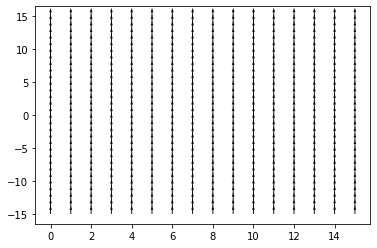

In [4]:
bsp2.VPlot(10)

That looks sensible, if not very revealing.

Visualizing the Non-Uniformity
------------------------------

As before, we can get a look at the wiggles if we blow up the x component of the field and do a stream plot.

<AxesSubplot:>

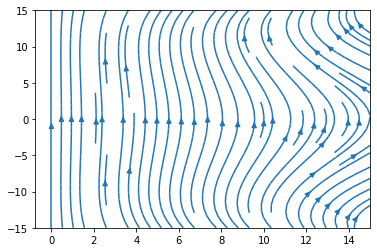

In [5]:
zbsp2 = fp.VectorField(bsp2)
zbsp2.u *= 100
zbsp2.StreamPlot()

Well, to my eye that is very similar to the pure Helmholtz version. GOOD.

Let's probe into the non-uniformity using the same technique as before.

The Non-Uniform Part of the Field
---------------------------------

A more instructive view is to look at the magnitude of the difference between this field magnitude and a uniform field matching the center value. I start by constructing this difference field and scale it to the central field. This gives us values which are fractional deviations from the central field. They are easier to interpret.

<Axes3DSubplot:>

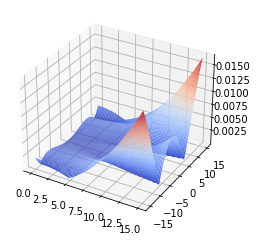

In [6]:
bmag = bsp2.Mag()
B0 = bmag.u[150,0]
bsp2diff = fp.ScalarField(bmag)
bsp2diff.u = np.abs(bsp2diff.u - B0 + 1e-9)
bsp2diff.u /= B0
bsp2diff.Splot(2)

Well, that is really different from the narrowed model. There is a wiggle on the axis but not the huge wings.

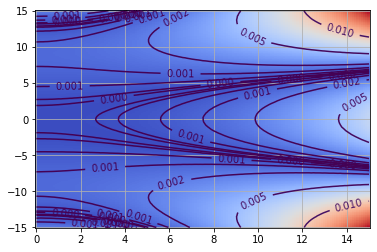

In [7]:
cax = bsp2diff.Cplot([1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1])
cax.grid(axis='both')

I am not sure that that is really any better than the 2cm narrowed version. It is quite hard to look at. Can we add coloring?

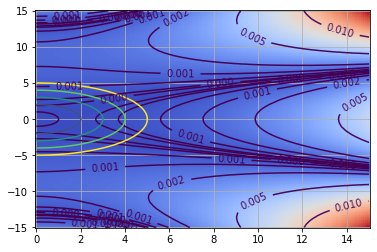

In [8]:
rf = fp.ScalarField(bmag)
rf.u = np.sqrt(rf.x * rf.x + rf.y * rf.y)
cax = bsp2diff.Cplot([1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1])
cax.grid(axis='both')
cax.contour(rf.x,rf.y,rf.u,levels=[1.0, 2.0,3,4,5])

So, with the coils narrowed by 2cm (only a 4% decrease in spacing) we have decreased our working volume from nearly 6cm radius to barely 2cm.

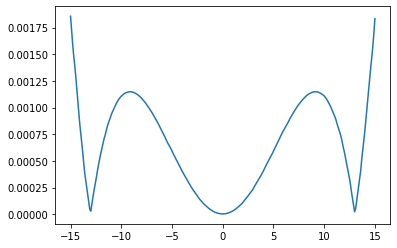

In [9]:
plt.plot(bsp2diff.y[:,0],bsp2diff.u[:,0])

Hm, well that says that we are plotting the difference from the wrong value, I think. Let's go back and look at the actual magnitude.

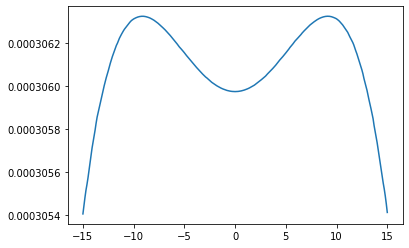

In [10]:
plt.plot(bmag.y[:,0],bmag.u[:,0])

So, what we really want to know about is the variation from the average value in middle 13 cm of the region, not from the center value. Note that there is still a slight asymmetry between top and bottom, but it is still small compared to all other effects.

Let's check the index limits corresponding to $\pm{}13\,cm$.

In [11]:
print(bmag.y[20,0],bmag.y[280,0])

-13.000000000000007 12.9999999999999


Close enough! Right so we find a new B0 as the average over this region and then construct a new difference from this.

In [12]:
B0 = np.average(bmag.u[20:281,0])
print(B0)

0.0003061631648732706


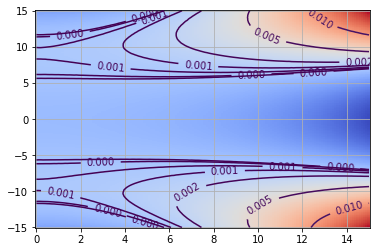

In [13]:
bmd2 = fp.ScalarField(bmag)
bmd2.u -= B0
bmd2.u /= B0
cax = bmd2.Cplot([1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1])
cax.grid(axis='both')

I find that immensely hopeful, but hard to interpret. Let's switch to a log scale.

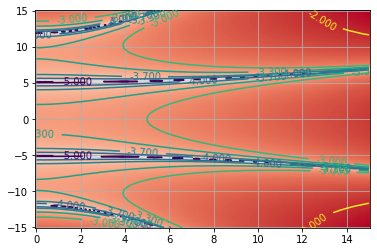

In [14]:
bml = fp.ScalarField(bmd2)
bml.u = np.log10(np.abs(bml.u))
cax = bml.Cplot([-5, -4, -3.7, -3.3, -3, -2])
cax.grid(axis='both')

Well that is interesting. We are not really getting a lot of $10^{-4}$ but we have a *huge* $10^{-3}$ region.

None of these methods actually asks the question "what is the largest region that is flat at the $10^{-4}$ level?". To get at that we have to set the average at 1.0001 times the central value.

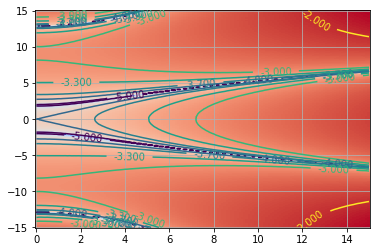

In [15]:
BAv = 1.0001 * bmag.u[150,0]
bmd3 = fp.ScalarField(bmag)
bmd3.u -= BAv
bmd3.u /= BAv
bmd3.u = np.log10(np.abs(bmd3.u))
cax = bmd3.Cplot([-5, -4, -3.7, -3.3, -3, -2])
cax.grid(axis='both')

(-5.0, 5.0)

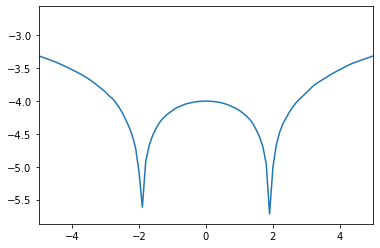

In [16]:
plt.plot(bmd3.y[:,0],bmd3.u[:,0])
plt.xlim((-5,5))

So we get flat at the $10^{-4}$ level only 2.5 cm away from the center. I am not sure that that is any better than the too close version.

At the $3\times10^{-4}$ level we get out to 4 cm away from the center. We do so much better in the transverse direction that we can ignore it as a decision variable.

I guess that if we really want to know what we get at the $3\times10^{-4}$ level then we have to redo the average. First, let's measure the peak-peak variation in the central region.

In [17]:
top = np.max(bmag.u[25:276,0])
bot = np.min(bmag.u[25:276,0])
print(bot, top, (top - bot)/(top + bot))

0.0003059757310084219 0.0003063260865895721 0.000572194253031268


So with a 4% increase in width we get a nearly $\pm6\times10^{-4}$ variation but over a region that stretches nearly 13 cm away from the center on axis. 

Using that as a target variation we can then find the size of the region which is flat at that level.

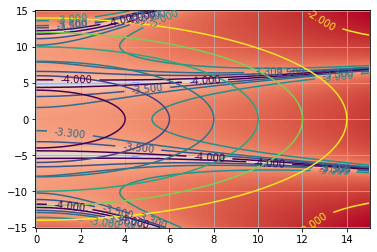

In [18]:
Bt = 0.5 * (top + bot)
bmd4 = fp.ScalarField(bmag)
bmd4.u -= Bt
bmd4.u /= Bt
bmd4.u = np.log10(np.abs(bmd4.u))
cax = bmd4.Cplot([-4, -3.5, -3.3, -3, -2])
cax.grid(axis='both')
cax.contour(rf.x,rf.y,rf.u,levels=[4, 6, 8, 10, 12, 14])

Just for good measure we will look at the on-axis plot.

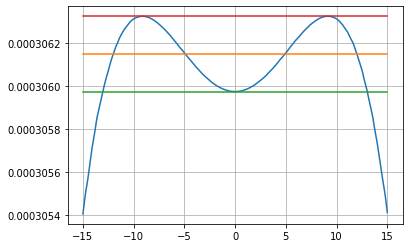

In [21]:
aline = np.zeros_like(bmag.u[:,0])
aline += Bt
lline = np.zeros_like(bmag.u[:,0])
lline += bot
tline = np.zeros_like(bmag.u[:,0])
tline += top
plt.plot(bmag.y[:,0],bmag.u[:,0])
plt.grid(axis='both')
plt.plot(bmag.y[:,0],aline)
plt.plot(bmag.y[:,0],lline)
plt.plot(bmag.y[:,0],tline)
#plt.xlim((-5,5))
#plt.ylim((0.000319, 0.00032))

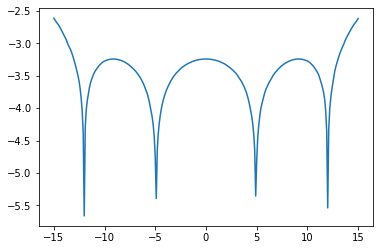

In [22]:
plt.plot(bmag.y[:,0],bmd4.u[:,0])

So on axis this works out to $\pm12$ cm, which is pretty amazing.

Let's look along the transverse direction.

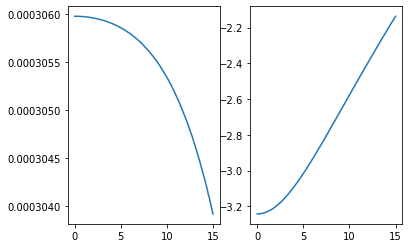

In [29]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.subplots_adjust(hspace=1.0)
axs[0].plot(bmag.x[150,:],bmag.u[150,:])
axs[1].plot(bmag.x[150,:],bmd4.u[150,:])

And there is the problem! We are never in spec in that direction. The field at the center is too low and it just goes on getting lower and lower the further you go off axis.